In [2]:
import pandas as pd
import numpy as np
from preprocessing import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

In [3]:
def N(t_scalar, t):
    """
    Returns the number of times in t less than or equal to t_scalar.
    Is used to compute N(t_{i,k}) and N'(t_{i,k}) depending on whether t above is t or t_prime
    """

    return np.searchsorted(t, t_scalar, side="right")

def compensator_m3(t_scalar, t_prime, lambda_i, alpha_i, beta_i):
    """
    t_scalar: scalar value where Lambda_i(t) is to be evaluated
    t_prime: list of arrival times at station i

    NOTE: t_prime NEEDS TO BE SORTED HERE.
    """

    term1 = lambda_i * t_scalar
    term2 = -(alpha_i / beta_i) * np.sum(np.exp(-beta_i * (t_scalar - t_prime[:N(t_scalar, t_prime)]))-1)
    return term1 + term2


In [4]:
def getTimeDifferences(t, t_prime):
    """
    Input: (sorted) times for a particular station i
    Output: List of differences indexed by [h][k] for this station i
    """

    # h goes until N(t[-1], t) assuming T = t[-1]
    T = end_T
    D_result = []
    for h in range(1, N(T, t)+1):
        differences_list = []
        # Construct list of t_ih - t'_ik for k = 1 to N'(T)
        differences_list.append(t[h-1] - t_prime[N(t[h-2], t_prime):N(t[h-1], t_prime)])

        D_result.append(np.array(differences_list))

    return D_result

In [5]:
def new_B(h, t, t_prime, beta, time_differences):

    """
    Returns a list of [B_i(1), ..., B_i(h)]

    NOTE: t_prime NEEDS to be sorted here

    time_differences: time differences double list for station i

    Note all index variables such as h, k, etc start at 1, like the mathematical notation.
    """
    B = [np.sum(np.exp(-beta*(t[0] - t_prime[:N(t[0], t_prime)])))]

    # Append the rest
    for l in range(2, h+1):
        # First term in recursive formula for B_i(h)
        term1 = np.exp(-beta*(t[l-1] - t[l-2])) * B[l-2]
        term2 = np.sum(np.exp(-beta*(time_differences[l-1])))
        B.append(term1 + term2)
    return np.array(B)

def new_m3_log_likelihood(t, t_prime, alpha_i, beta_i, lambda_i, time_differences):
    """
    Gives log likelihood of our three parameters. 
    t: start times from station i
    t_prime: end times at station i

    NOTE: t_prime NEEDS TO BE SORTED HERE
    """
    
    T = end_T # TODO: Is this how we get big T?

    # Get B list 
    B_ = new_B(len(t), t, t_prime, beta_i, time_differences)

    #term1 = np.sum(np.log(lambda_i + alpha_i*B_))
    term1 = np.sum(np.log(lambda_i + alpha_i*B_[:len(t)+1]))

    term2 = -compensator_m3(T, t_prime, lambda_i, alpha_i, beta_i)

    return term1 + term2


## Finding the parameters using likelihood optimisation

In [6]:
time_diffs = {}
for st_id in tqdm(train_sorted_start_ids):
    t = t_per_station[st_id]
    t_prime = t_prime_per_station[st_id] # Need to sort t_prime for likelihood function
    time_diffs[st_id] = getTimeDifferences(t, t_prime)

100%|██████████| 789/789 [00:13<00:00, 57.31it/s]


In [7]:
# optimal_parameters = {}
# for st_id in tqdm(train_sorted_start_ids):
#     x0 = [np.log(0.01), np.log(0.1), np.log(0.01)] # np.log(rates_dict[station.start_id.unique()[0]])]
#     # TODO: What bounds should we use here?
#     t = t_per_station[st_id]
#     t_prime = t_prime_per_station[st_id] # Need to sort t_prime for likelihood function
#     time_differences = time_diffs[st_id]

#     op_m3_likelihood = lambda x: -new_m3_log_likelihood(t, t_prime, np.exp(x[0]), np.exp(x[0]) + np.exp(x[1]), np.exp(x[2]), time_differences)
#     sol = op.minimize(op_m3_likelihood, x0, method="Nelder-Mead")

#     #sol = op.minimize(op_m3_likelihood, x0, method="SLSQP")
#     if sol.success:
#         transformed_alpha = np.exp(sol.x[0])
#         transformed_beta = np.exp(sol.x[1]) + np.exp(sol.x[0])
#         transformed_lambda = np.exp(sol.x[2])
#         max_params = [transformed_alpha, transformed_beta, transformed_lambda]
#         optimal_parameters[st_id] = max_params
#     else:
#         raise OptimizationError(f"Failed to converge for station {st_id}.")
# optimal_parameters

In [8]:
# param_df = pd.DataFrame(optimal_parameters.values(), index=optimal_parameters.keys(), columns = ["alpha", "beta", "lambda"])
# param_df.head() 
# param_df.to_csv("../data/parameters/M3_train_params.csv")

## Assessing fit for model 3

In [9]:
m3_parameters = pd.read_csv("../data/parameters/M3_train_params.csv", index_col=0)
m3_parameters

,alpha,beta,lambda
1,0.020179,0.035553,7.705058e-03
2,0.015271,0.016036,1.213006e-03
3,0.004644,0.004644,3.779973e-17
4,0.009820,0.023543,9.676464e-03
5,0.011876,0.012869,1.258996e-03
...,...,...,...
836,0.014502,0.039605,1.707352e-02
838,0.006228,0.006470,4.663218e-04
839,0.023140,0.028994,8.233945e-03
840,0.018468,0.019006,2.030979e-04


In [10]:
compensated_times_dict_train = {}
for st_id in tqdm(train_sorted_start_ids):
    params = m3_parameters.loc[st_id].to_numpy()
    tprime = t_prime_per_station[st_id]
    time = t_per_station[st_id]
    comp_st = lambda x: compensator_m3(x, tprime, params[2], params[0], params[1])
    compensated_times_dict_train[st_id] = [comp_st(i) for i in time]

compensated_times_dict_test = {}
for st_id in tqdm(test_sorted_start_ids):
    params = m3_parameters.loc[st_id].to_numpy()
    tprime = test_t_prime_per_station[st_id]
    time = test_t_per_station[st_id]
    comp_st = lambda x: compensator_m3(x, tprime, params[2], params[0], params[1])
    compensated_times_dict_test[st_id] = [comp_st(i) for i in time]

100%|██████████| 788/788 [00:07<00:00, 106.16it/s]


In [11]:
m3_compensated_times_train_df = pd.DataFrame(compensated_times_dict_train.values(), index=compensated_times_dict_train.keys())
m3_compensated_times_train_df.to_csv("../data/compensated_times/M3_compensated_times_train.csv")

In [12]:
m3_compensated_times_test_df = pd.DataFrame(compensated_times_dict_test.values(), index=compensated_times_dict_test.keys())
m3_compensated_times_test_df.to_csv("../data/compensated_times/M3_compensated_times_test.csv")

In [13]:
from statsmodels.tsa.stattools import acf

array([1.        , 0.99673831, 0.99347574, 0.99019929, 0.98691641,
       0.98363045, 0.98035626, 0.97716825, 0.97399973, 0.97082369,
       0.96766888, 0.96450725, 0.9613405 , 0.95816336, 0.95499816,
       0.95182477, 0.9486368 , 0.9454428 , 0.94223671, 0.93902048,
       0.93579099, 0.93256163, 0.92932604, 0.92608789, 0.92284267,
       0.91959945, 0.9163504 , 0.91308876, 0.90981679, 0.90655327])

In [10]:
m3_p_values_train = {}
for st_id in tqdm(train_sorted_start_ids):
    inter_arrival_times = np.diff(compensated_times_dict_train[st_id])
    inter_arrival_times = np.insert(inter_arrival_times,0,compensated_times_dict_train[st_id][0])
    station_p_values = np.exp(-inter_arrival_times)
    m3_p_values_train[st_id] = station_p_values

m3_p_values_test = {}
for st_id in tqdm(test_sorted_start_ids):
    inter_arrival_times = np.diff(compensated_times_dict_test[st_id])
    inter_arrival_times = np.insert(inter_arrival_times,0,compensated_times_dict_test[st_id][0])
    station_p_values = np.exp(-inter_arrival_times)
    m3_p_values_test[st_id] = station_p_values

100%|██████████| 788/788 [00:00<00:00, 27109.74it/s]


In [11]:
m3_p_values_df_train = pd.DataFrame(m3_p_values_train.values(), index=m3_p_values_train.keys())
m3_p_values_df_train.to_csv("../data/p_values/M3_p_values_train.csv")
m3_p_values_df_test = pd.DataFrame(m3_p_values_test.values(), index=m3_p_values_test.keys())
m3_p_values_df_test.to_csv("../data/p_values/M3_p_values_test.csv")

In [17]:
m3_p_values_df = pd.DataFrame(m3_p_values.values(), m3_p_values.keys())
m3_p_values_df.to_csv("../data/p_values/M3_p_values.csv")

,0,1,2,3,4,5,6,7,8,9,...,4352,4353,4354,4355,4356,4357,4358,4359,4360,4361
1,0.000000e+00,0.094925,0.847831,0.584853,0.565317,0.546002,0.826116,0.687242,0.302821,0.048982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.160372e-64,0.247700,0.528936,0.854210,0.613427,0.272850,0.744822,0.934266,0.642988,0.901173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.382751e-02,0.814351,0.021531,0.009565,0.119887,0.288482,0.300152,0.641640,0.466563,0.979284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000e+00,0.984674,0.048421,0.993566,0.536288,0.754701,0.879930,0.998679,0.549401,0.806442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.667103e-67,0.749586,0.094187,0.988748,0.886160,0.253819,0.927181,0.070867,0.472580,0.380236,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


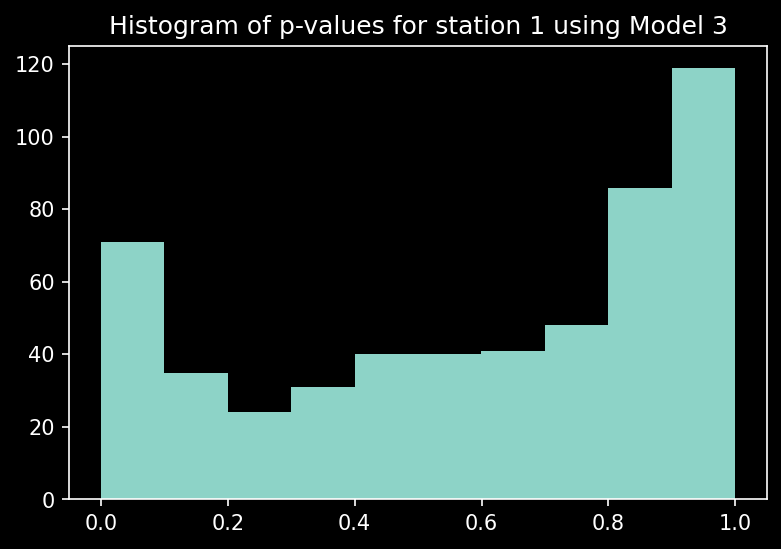

In [35]:
plt.title("Histogram of p-values for station 1 using Model 3")
plt.hist(m3_p_values[1])
plt.show()

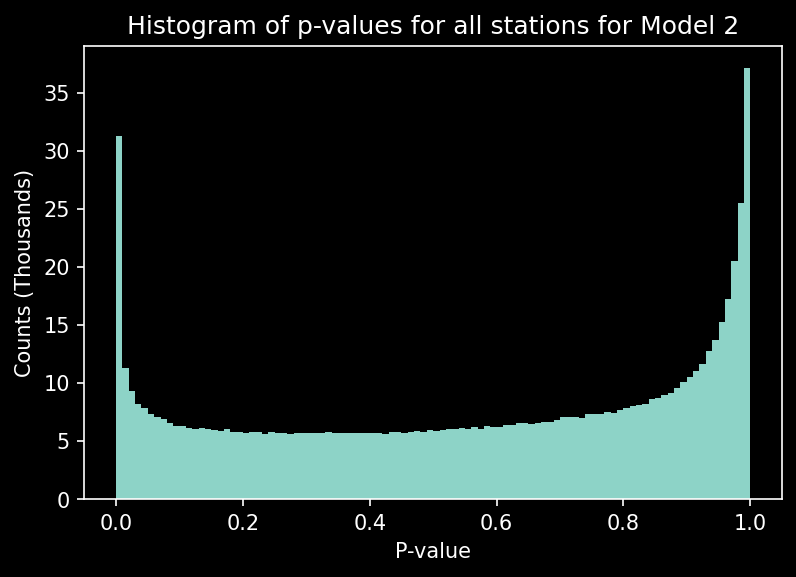

In [36]:
joined_p_values = np.concatenate(np.array(list(m3_p_values.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations for Model 2")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values_m3.png")
plt.show()

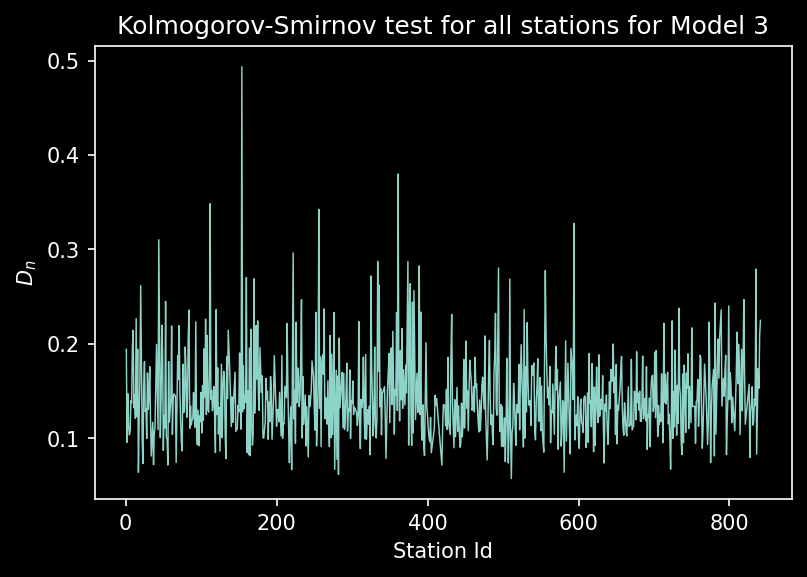

In [37]:
kol_smir_test = {}
for station_id, pvals in m3_p_values.items():
    kol_smir_test[station_id] = st.kstest(pvals, "uniform").statistic

plt.plot(kol_smir_test.keys(), kol_smir_test.values(), linewidth=0.7)
plt.title("Kolmogorov-Smirnov test for all stations for Model 3")
plt.xlabel("Station Id")
plt.ylabel("$D_n$")
plt.savefig("../figures/kol-smir_m3.png")
plt.show()

In [38]:
ks_df = pd.DataFrame(kol_smir_test.values(), index=kol_smir_test.keys(), columns = ["ks"])
ks_df.head()
outlier_ids = ks_df[ks_df.ks > 0.5].index.to_numpy()
print(outlier_ids)
for id in outlier_ids:
    print(optimal_parameters[id])

[]


In [39]:
popularity_dict = {}
for station_id in m3_p_values.keys():
    popularity_dict[station_id] = len(test_bike_data[test_bike_data.start_id == station_id])


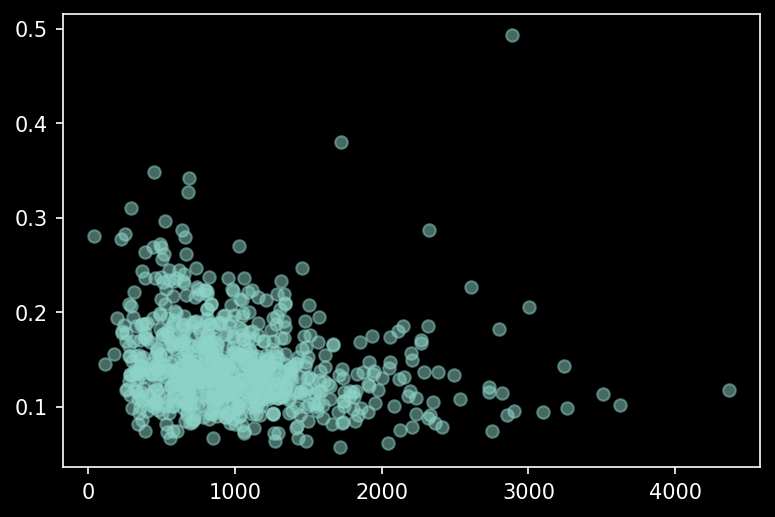

In [40]:
plt.scatter(popularity_dict.values(), kol_smir_test.values(), alpha=0.5)
plt.show()

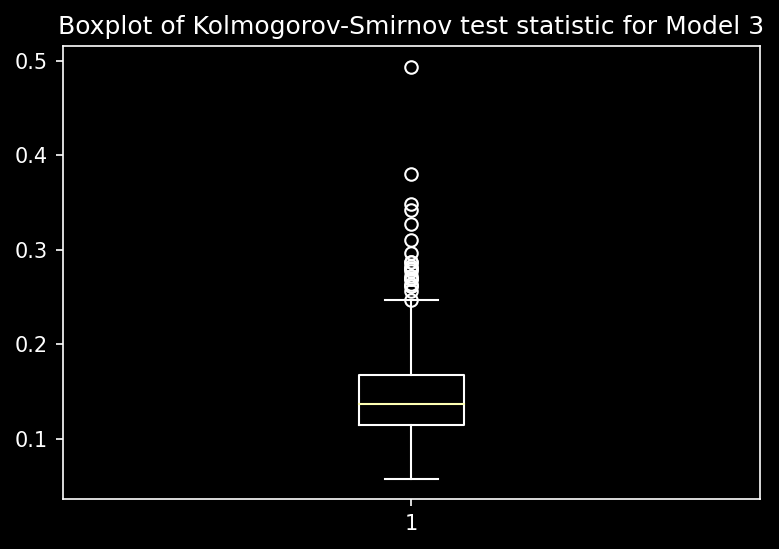

In [24]:
plt.boxplot(kol_smir_test.values())
plt.title("Boxplot of Kolmogorov-Smirnov test statistic for Model 3")
plt.show()

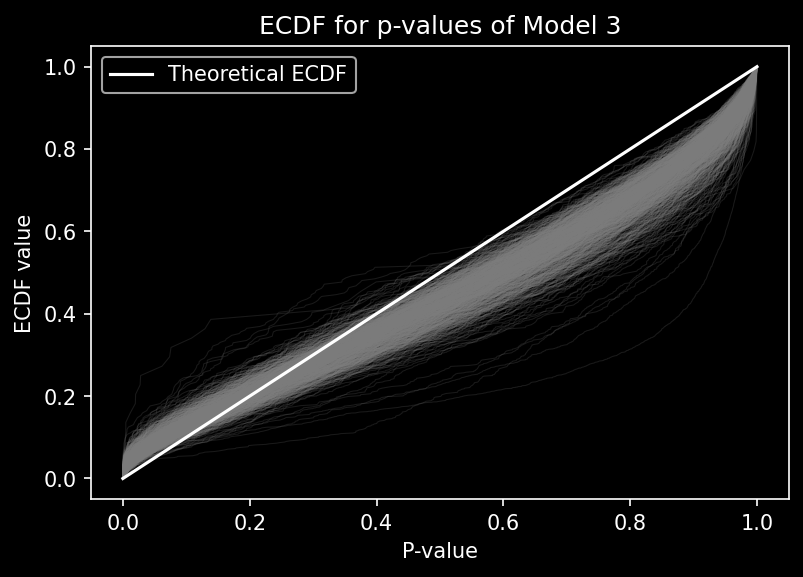

In [25]:
for station, pvals in m3_p_values.items():
    x,y = ecdf(pvals)
    plt.plot(x,y, alpha=0.2, linewidth=0.5, color="gray")

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], color="white", label="Theoretical ECDF")
plt.legend()
plt.show()